# ALPro Tests
This notebook is designed to document some simple tests of the photon-ALP propagation code ALPro. For most of the tests we will use $m_a = 10^{-13}~{\rm eV}$ and $g_a = 10^{-13}~{\rm GeV}^{-1}$. 

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np 
import constants as c
import os
import alpro 
from scipy.interpolate import interp1d
alpro.util.set_default_plot_params(tex=True)

def test_pass_fail(energy, P1, P2, threshold=1e-6, name="", absolute=False):
    relative_error = np.fabs((P1-P2)/P1)
    message = "Fail: {}".format(name)
    if absolute:
        test_bool = np.fabs(P1-P2) < threshold
    else:
        test_bool = ((relative_error < threshold) + (P1 < 1e-6))
    assert np.all(test_bool), message
    return 

In [30]:
#this is our energy array in units of eV
energy = np.logspace(6,7,100000)

# set parameters of problem for all of the basic tests (Marsh test uses different values)
B = 1e-5          # 10 micro G
g = 1e-13 * 1e-9   # 1e-9 GeV^-1
mass = 1e-13      # 1e-12 eV
L = 10.0          # 10 kpc
ne = 100          # 100 particle cm^-3 (sets plasma frequency)

## Single Domain Test
First, let's compare an idealised pure polarization state solution to the analytic solution given by

$$ P_{\gamma \rightarrow a} = \frac{\Theta^2}{1+\Theta^2} \sin^2 (\Delta_{\rm eff} \sqrt{1+\Theta^2} L) $$. 

The model here is a single domain of width $10~{\rm kpc}$, with uniform field $B=10 \mu{\rm G}$ oriented along the $y$-axis. The polarization state is $(0,1,0)$.

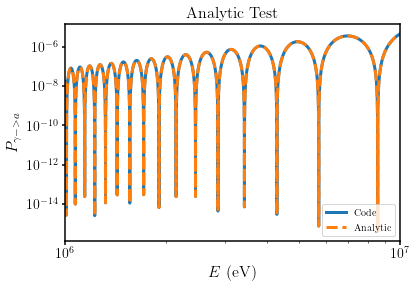

In [31]:
# Initial state {0,1,0}
Ainit = np.zeros( (len(energy),3), dtype=np.complex128)
Ainit[:,1] = 1.0 + 0.0j
phi = np.zeros_like(energy) #aligned field

# get code result and plot 
P, Anew = alpro.get_P(energy, Ainit, phi, B, L, g, mass, ne)
plt.plot(energy, P, label="Code", lw=3)

#print (mass, omega_pl)
prediction = alpro.util.P_gamma_analytic(energy, B, ne, mass, g, L)
plt.plot(energy, prediction,  ls="--", lw=3, label="Analytic")

# label
plt.loglog()
plt.legend()
plt.xlabel("$E$ (eV)", fontsize=16)
plt.ylabel("$P_{\gamma->a}$", fontsize=16)
plt.xlim(1e6,1e7)
title = plt.title("Analytic Test", fontsize=16)

test_pass_fail(energy, prediction, P, name="Test 1, Analytic")

## Discretisation Test
In our second test, we compare a single domain to a discretised uniform field. Specifically the result from 1 uniform cell of size $L$ to $10$ uniform cells of size $L/10$. This should give an identical result. We use a pure polarisation state $(0,1,0)$ and a B-field aligned with the y axis. 

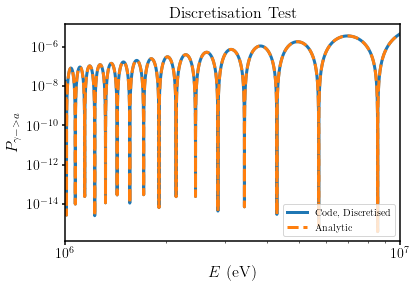

In [32]:
# now do the discretised version
# Initial state {0,1,0}
Ainit = np.zeros( (len(energy),3), dtype=np.complex128)
Ainit[:,1] = 1.0 + 0.0j
phi = np.zeros_like(energy) #aligned field
Anew = Ainit
Nshells = 10
for i in range(Nshells):
    Ainit = Anew
    P1, Anew = alpro.get_P(energy, Ainit, phi, B, L/Nshells, g, mass, ne)
plt.plot(energy, P1, c="C0", ls="-", lw=3, label="Code, Discretised")

prediction = alpro.util.P_gamma_analytic(energy, B, ne, mass, g, L)
plt.plot(energy, prediction,  ls="--", lw=3, label="Analytic", c="C1")

# label
plt.legend()
plt.loglog()
plt.xlim(1e6,1e7)
plt.xlabel("$E$ (eV)", fontsize=16)
plt.ylabel("$P_{\gamma->a}$", fontsize=16)
title = plt.title("Discretisation Test", fontsize=16)

test_pass_fail(energy, prediction, P, name="Test 2, Discretisation")

## Testing against Marsh using Libanov field
This tests a uniform field model from Libanov \& Troitsky (2020) against David Marsh's code and from data digitised from the Libanov paper. This test uses a large scale uniform field and energies in the GeV regime. The field components are given by 

$$
B_r = \frac{2 \cos\theta}{r^2} f(r) \\
B_\theta = - \frac{\sin \theta}{r} f'(r)  \\
B_\phi = \frac{\alpha \sin \theta}{r} f(r) \, ,
$$

where $\alpha$ solves a transcendental equation and is approximately given by  $\alpha= 5.76$. The function $f(r)$ is given by

$$
f(r) =c_1\Big(
\alpha \cos (\alpha u) - \frac{\sin(\alpha u)}{u}
- u^2\left(
\alpha \cos\alpha - \sin \alpha
\right)
\Big) \, .
$$

The form of the field is plotted below, before we plot the ALP result. Note that this is now the **survival** probability on a linear axis. We find cosmetically perfect agreement between our results and Marsh. the Libanov results are smoothed with the Fermi response which is presumably the reason for the difference, but the overall form is similar. 

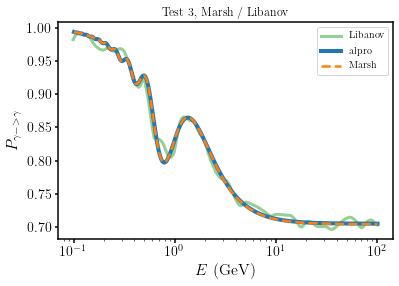

In [33]:
# load data from Marsh and Libanov codes 
folder = os.path.dirname(alpro.__file__)
energies_m, P_m = np.genfromtxt("{}/data/marsh_test.dat".format(folder), unpack=True)
energies_l, P_l = np.genfromtxt("{}/data/libanov.dat".format(folder), unpack=True)
plt.plot(energies_l, P_l, ls="-", alpha=0.5, label="Libanov", lw=3, c="C2")

energies = energies_m * 1e9
s = alpro.Survival("libanov")
s.init_model()
mass = 1e-9
g = 1e-11 * 1e-9
s.set_params(g, mass)
s.domain.rm = 0.0
P = s.get_curve(energies, 1.0, 93.0, r0=0.0)
plt.plot(energies / 1e9, 1-P, lw=4, label="alpro", c="C0")
plt.plot(energies_m, P_m, lw=2.5, ls="--", label="Marsh", c="C1")
plt.semilogx()

plt.xlabel("$E$ (GeV)", fontsize=16)
plt.ylabel("$P_{\gamma->\gamma}$", fontsize=16)
plt.legend()
plt.title("Test 3, Marsh / Libanov")

test_pass_fail(energies, 1.0-P_m, P, name="Test 3, Marsh / Libanov", threshold=5e-2)

## Domain Field Test v Carenza 


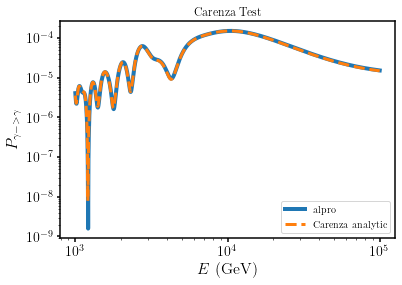

In [35]:
mass = 1e-11
g = 1e-12 * 1e-9
def setup_carenza_model():
    s = alpro.Survival("custom")
    s.init_model()
    r, f = np.genfromtxt("data/Bfield_Carenza.dat", unpack=True)
    
    s.set_params(g, mass)
    s.domain.deltaL = r[1:] - r[:-1]
    s.domain.r = r[:-1]
    s.domain.rcen = 0.5 * (r[1:] + r[:-1])
    s.domain.ne = np.zeros_like(s.domain.r) 
    Btot = 1e-6
    s.domain.Bx = f[:-1] * Btot
    s.domain.By = np.zeros_like (s.domain.Bx)
    s.domain.B = np.sqrt(s.domain.Bx**2  + s.domain.By **2)
    s.domain.phi = np.arctan2(s.domain.Bx,s.domain.By)
    return (s) 

energies,P = np.genfromtxt("data/Prob_Carenza.dat", unpack=True)

s = setup_carenza_model()
Pcode, _ = s.propagate(s.domain, energies, pol="x")
plt.plot(energies, Pcode, lw=4, label="alpro", c="C0")

plt.plot(energies, P, c="C1", ls="--", label="Carenza analytic")
error = np.fabs(P-Pcode)
#plt.plot(energies, error/P, c="C3")

plt.semilogx()
plt.xlabel("$E$ (GeV)", fontsize=16)
plt.ylabel("$P_{\gamma->\gamma}$", fontsize=16)
plt.legend()
_ = plt.title("Carenza Test")
plt.loglog()

test_pass_fail(energies, P, Pcode, name="Test 4, Carenza", threshold=1e-5, absolute=True)

### Testing against Fourier-like methods
